# Google Colab Configuration

**Execute this steps to configure the Google Colab environment in order to execute this notebook. It is not required if you are executing it locally and you have properly configured your local environment according to what explained in the Github Repository.**

The first step is to clone the repository to have access to all the data and files.

In [ ]:
! git clone https://github.com/acastellanos-ie/MBD-EN-BL-ENE-2020-J-1.git

Cloning into 'MBD-EN-BL-ENE-2020-J-1'...
remote: Enumerating objects: 4527, done.
remote: Counting objects: 100% (4527/4527), done.
remote: Compressing objects: 100% (4347/4347), done.
remote: Total 4527 (delta 190), reused 4480 (delta 161), pack-reused 0
Receiving objects: 100% (4527/4527), 13.46 MiB | 21.81 MiB/s, done.
Resolving deltas: 100% (190/190), done.


Install the requirements

In [ ]:
! pip install -r MBD-EN-BL-ENE-2020-J-1/requirements.txt

  Cloning https://github.com/amaiya/eli5 (to revision tfkeras_0_10_1) to /tmp/pip-req-build-2kgk50wv
  Running command git clone -q https://github.com/amaiya/eli5 /tmp/pip-req-build-2kgk50wv
  Running command git checkout -b tfkeras_0_10_1 --track origin/tfkeras_0_10_1
  Switched to a new branch 'tfkeras_0_10_1'
  Branch 'tfkeras_0_10_1' set up to track remote branch 'tfkeras_0_10_1' from 'origin'.
  Cloning https://github.com/amaiya/stellargraph (to revision no_tf_dep_082) to /tmp/pip-req-build-c26m23j9
  Running command git clone -q https://github.com/amaiya/stellargraph /tmp/pip-req-build-c26m23j9
  Running command git checkout -b no_tf_dep_082 --track origin/no_tf_dep_082
  Switched to a new branch 'no_tf_dep_082'
  Branch 'no_tf_dep_082' set up to track remote branch 'no_tf_dep_082' from 'origin'.
     |████████████████████████████████| 358kB 9.2MB/s 
     |████████████████████████████████| 727kB 15.5MB/s 
     |████████████████████████████████| 454.3MB 39kB/s 
     |█████████████

# Imports and Configuration

In [ ]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Matplotlib conf
import matplotlib.pyplot as plt
%matplotlib inline

# Seaborn conf
import seaborn as sns
sns.set_palette(sns.color_palette("seismic"))

import sys

import pandas as pd
import numpy as np
import operator
import string
import nltk

import tensorflow as tf
import ktrain
from ktrain import text

from google.colab import drive
drive.mount('/content/gdrive')

df = pd.read_csv('/content/gdrive/MyDrive/train.csv')

df = df.drop(columns=['qid'])
print(df.head())



Mounted at /content/gdrive
                                       question_text  target
0  How did Quebec nationalists see their province...       0
1  Do you have an adopted dog, how would you enco...       0
2  Why does velocity affect time? Does velocity a...       0
3  How did Otto von Guericke used the Magdeburg h...       0
4  Can I convert montra helicon D to a mountain b...       0


## Inspecting the data

The dataset is taken from Kaggle competition (Quora Insincere Questions Classification)


An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

- Has a non-neutral tone

 - Has an exaggerated tone to underscore a point about a group of people
 - Is rhetorical and meant to imply a statement about a group of people
- Is disparaging or inflammatory

 - Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
 - Makes disparaging attacks/insults against a specific person or group of people
 - Based on an outlandish premise about a group of people
 - Disparages against a characteristic that is not fixable and not measurable 
- Isn't grounded in reality
 - Based on false information, or contains absurd assumptions
 - Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers

The training data includes the question that was asked, and whether it was identified as insincere (target = 1)
### Class distribution


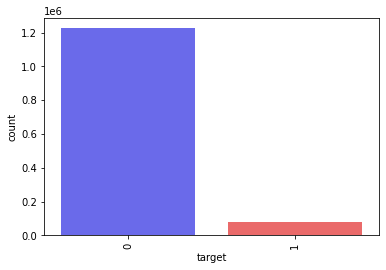

In [ ]:
sns.countplot(x=df.target, order=[x for x, count in sorted(Counter(df.target).items(), key=lambda x: -x[1])], palette="seismic")
plt.xticks(rotation=90);

The target class has around 60k records, where as the non-target has 1.2 million records. This is a clear example of a class imbalance classification.

# Modelling with Transforerms



## Create the Transformer Model

First, we will preprocess the dataset with ktrain library, create a Text Classifier based on a Transformer model.


Then we start with a Language Model pre-trained using a massive dataset. The model is BERT where it applies the idea of Self-Attention (instead of an RNN architecture) to learn the sequential information of textual contents.


It is needed to fine-tune this model, so we will re-train the model to our specific dataset.

In [ ]:
trn, val, preproc = text.texts_from_df(df,'question_text',preprocess_mode='bert',label_columns='target',verbose=True, maxlen=32) # Process the input questions based on the BERT encoder

model = text.text_classifier('bert', trn, preproc=preproc) # Create a text classifier that uses the BERT-based representations created before

learner = ktrain.get_learner(model, train_data=trn, val_data=val,  batch_size=128) # Creates the learning process to fine-tune bert and train the classifier.

['not_target', 'target']
        not_target  target
316565         1.0     0.0
951115         1.0     0.0
55210          1.0     0.0
122975         1.0     0.0
791368         1.0     0.0
['not_target', 'target']
         not_target  target
614888          1.0     0.0
1140011         1.0     0.0
810856          1.0     0.0
625054          1.0     0.0
231097          1.0     0.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


Is Multi-Label? False
maxlen is 32
done.


## Train the Model

It is now time to actually train (fine-tuning + train the text classifier) the model. This process might take a while. BERT is huge and memory-hungry. Consequently, it is pretty slow for both training and prediction. 

In [ ]:
learner.lr_find(show_plot=True, max_epochs=1)

simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


   4/9184 [..............................] - ETA: 86:26:25 - loss: 0.2644 - accuracy: 0.9316

In [ ]:
learner.autofit(lr=1e-4, # Learning Rate 
                epochs=1, # Number of epochs to train the model
                early_stopping=1, # If the model does not improve after 2 epochs, we stop the training
                reduce_on_plateau=1,  # If the model does not improve aftear 1 epoch, we reduce the learning rate
                monitor='val_loss', # Metric to monitor the peformance of the model (loss computed on the validation dataset)
                checkpoint_folder='transformer_cpt_1' # After each epoch we store a checkpoint of the model
                )



begin training using triangular learning rate policy with max lr of 0.0001...
9184/9184 [==============================] - 9743s 1s/step - loss: 0.1013 - accuracy: 0.9595 - val_loss: 0.0905 - val_accuracy: 0.9636
Weights from best epoch have been loaded into model.


In [ ]:
learner.save_model('transformer_1') # Saving the trained model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Evaluate and Inspect the Model

Large Deep Learning models are well-known for being quite black-boxy. However, in this section, I would like to provide you with some tools to evaluate and analyze them.

Below is the confussion matrix to understand the performance of the model and to check the accuracy and F-measure.


In [ ]:
learner.validate(class_names=['Normal Question','Abnormal Question'])

                   precision    recall  f1-score   support

  Normal Question       0.98      0.98      0.98    122386
Abnormal Question       0.72      0.68      0.70      8227

         accuracy                           0.96    130613
        macro avg       0.85      0.83      0.84    130613
     weighted avg       0.96      0.96      0.96    130613



array([[120240,   2146],
       [  2607,   5620]])

ktrain, actually provides an `explain` method to know that. It allows you to inspect a given tweet and visualize which words contributed the most on deciding the final prediction. We will need a forked version of the **eli5** library that supportes TensorFlow Keras, so let's install it first.

In [ ]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1


And call the `explain` function

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)

predictor.explain("can we prevent women from voting?")

# Re-load the trained model


In [ ]:
reloaded_predictor = ktrain.load_predictor('/content/gdrive/MyDrive/TeamB_predictor')

In [ ]:
data = ['can women vote?']

reloaded_predictor.predict(data)


['not_target']


### With model interpretability using eli5:

In [ ]:
reloaded_predictor.explain("can we prevent women from voting or not?")
